**Import the Libraries**

In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
print(tf.__version__)

2021-12-03 10:18:18.834951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 10:18:18.834988: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.7.0


**Get the Data**

**Import NTLK Library**

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/abdel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Set the Hyper-Parameters**

In [3]:
vocab_size = 50000 
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' #OOV = Out of Vocabulary
training_portion = .6
validation_portion = .2
test_portion = .2

**Populate List and Remove the Stopwords**

In [25]:
articles = []
labels = []

with open("train.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(''.join(e for e in row[3] if e.isalnum()))
        title = row[1]
        description = row[2]
        article = str(title) + ' ' + str(description) 
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)

In [5]:
labels[:2]

['Arts,', 'Cell']

In [6]:
articles[:2]

['TUNGSTEN SOLDER PICK WITH HANDLESolder Pick picking molten solder making jewelry',
 'Write Right 98167 Screen Protector Sony T615CWe screen. And need protect screens expensive little gadgetry. Our pack (12) clear screen protectors, generous 2-15/16" x 2-1/4" x .004" thick. They protect scratches reduce glare. Made Sony Cli, easy cut fit anything screen want protect. Made USA Fellowes.']

**Create Training and Validation Set**

In [26]:
train_size = int(len(articles) * training_portion)
validation_size = int(len(articles) * validation_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:train_size + validation_size]
validation_labels = labels[train_size:train_size + validation_size]

test_articles = articles[train_size + validation_size:]
test_labels = labels[train_size + validation_size:]

print("train_size",  train_size)
print(f"train_articles {len(train_articles)}")
print("train_labels", len(train_labels))
print("validation_articles", len(validation_articles))
print("validation_labels", len(validation_labels))

train_size 36983
train_articles 36983
train_labels 36983
validation_articles 9246
validation_labels 9246


**Tokenization on "train_articles"**

In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

**Convert to Sequences on "train_articles"**

In [9]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [10]:
print(train_sequences[10]), len(train_sequences[10])

[23571, 657, 19682, 3808, 2, 28, 591, 834, 819, 657, 6360, 693, 2972, 164, 303, 3808, 1899, 44, 2143, 561, 9699, 28, 267, 164, 4156, 561, 9963, 28, 94, 1590, 562, 1284, 28, 1937, 5472, 74, 562, 861, 6640, 2, 811, 164, 4269, 12, 28, 212, 72, 328, 10545, 28, 785, 244, 600, 28, 2972, 164, 5891, 653, 96, 2446, 8646, 75, 13415, 28, 8647, 1681, 11988, 1322, 8827, 13416, 12407, 226, 13417, 226, 13418, 13419, 12408, 1104, 12409, 1212, 13420, 13421, 8647, 454, 12903, 146, 8827, 12904, 13422, 1035, 13423, 1681, 13424, 13985, 94, 13425, 1774, 13986, 1035, 13987, 13426, 25, 57, 10, 9205, 25, 57, 164, 1545, 1233, 7268, 3947, 1125, 1754, 574, 338, 7681, 25, 965]


(None, 119)

In [11]:
print(train_sequences[0]), len(train_sequences[0])

[3648, 12406, 1575, 58, 1, 1575, 6448, 21353, 12406, 275, 1475]


(None, 11)

**Padding and Truncating on "train_sequences"**

In [12]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
train_padded[10]

array([23571,   657, 19682,  3808,     2,    28,   591,   834,   819,
         657,  6360,   693,  2972,   164,   303,  3808,  1899,    44,
        2143,   561,  9699,    28,   267,   164,  4156,   561,  9963,
          28,    94,  1590,   562,  1284,    28,  1937,  5472,    74,
         562,   861,  6640,     2,   811,   164,  4269,    12,    28,
         212,    72,   328, 10545,    28,   785,   244,   600,    28,
        2972,   164,  5891,   653,    96,  2446,  8646,    75, 13415,
          28,  8647,  1681, 11988,  1322,  8827, 13416, 12407,   226,
       13417,   226, 13418, 13419, 12408,  1104, 12409,  1212, 13420,
       13421,  8647,   454, 12903,   146,  8827, 12904, 13422,  1035,
       13423,  1681, 13424, 13985,    94, 13425,  1774, 13986,  1035,
       13987, 13426,    25,    57,    10,  9205,    25,    57,   164,
        1545,  1233,  7268,  3947,  1125,  1754,   574,   338,  7681,
          25,   965,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [14]:
print("len train_sequnces[0]: ", len(train_sequences[0]))
print("len train_padded[0]: ", len(train_padded[0]))

print("len train_sequences[1]: ", len(train_sequences[1]))
print("len train_padded[1]: ", len(train_padded[1]))

print("len train_sequences[10]: ", len(train_sequences[10]))
print("len train_padded[10]: ", len(train_padded[10]))

len train_sequnces[0]:  11
len train_padded[0]:  200
len train_sequences[1]:  50
len train_padded[1]:  200
len train_sequences[10]:  119
len train_padded[10]:  200


**Convert to Sequence, Padding & Truncating on "validation_articles"**

In [15]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

9246
(9246, 200)


**Labels**

In [16]:
print(set(labels))

{'Grocery', 'Patio,', 'Office', 'Arts,', 'Toys', 'Tools', 'Electronics', 'Automotive', 'Health', 'Industrial', 'Beauty', 'Appliances', 'Musical', 'Clothing,', 'Sports', 'All', 'Pet', 'Cell', 'Baby'}


**Tokenize and Convert to Sequence on "train_labels" and "validation_labels"**

In [17]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [18]:
#labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
label_tokenizer.word_index

{'baby': 1,
 'all': 2,
 'arts': 3,
 'beauty': 4,
 'sports': 5,
 'grocery': 6,
 'cell': 7,
 'clothing': 8,
 'tools': 9,
 'health': 10,
 'patio': 11,
 'electronics': 12,
 'automotive': 13,
 'toys': 14,
 'office': 15,
 'appliances': 16,
 'musical': 17,
 'industrial': 18,
 'pet': 19}

In [19]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)
print('-------------')
print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[3]
[7]
[8]
(36983, 1)
-------------
[1]
[5]
[3]
(9246, 1)


**Create Model**

In [20]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(20, activation='softmax'))

model.summary()

2021-12-03 10:18:45.374527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-03 10:18:45.374594: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-03 10:18:45.374676: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (abdel-EliteBook): /proc/driver/nvidia/version does not exist


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          3200000   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 20)                2580      
                                                                 
Total params: 3,268,628
Trainable params: 3,268,628
Non-trainable params: 0
_________________________________________________________________


**Compile the Model**

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

**Train the Model**

In [22]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
1156/1156 - 362s - loss: 1.7484 - accuracy: 0.4650 - val_loss: 0.9305 - val_accuracy: 0.7295 - 362s/epoch - 313ms/step
Epoch 2/10
1156/1156 - 304s - loss: 0.6423 - accuracy: 0.8131 - val_loss: 0.6755 - val_accuracy: 0.8039 - 304s/epoch - 263ms/step
Epoch 3/10
1156/1156 - 289s - loss: 0.3670 - accuracy: 0.8931 - val_loss: 0.6573 - val_accuracy: 0.8142 - 289s/epoch - 250ms/step
Epoch 4/10
1156/1156 - 303s - loss: 0.2377 - accuracy: 0.9305 - val_loss: 0.6844 - val_accuracy: 0.8226 - 303s/epoch - 262ms/step
Epoch 5/10
1156/1156 - 325s - loss: 0.1667 - accuracy: 0.9510 - val_loss: 0.7176 - val_accuracy: 0.8168 - 325s/epoch - 281ms/step
Epoch 6/10
1156/1156 - 350s - loss: 0.1237 - accuracy: 0.9630 - val_loss: 0.7878 - val_accuracy: 0.8153 - 350s/epoch - 302ms/step
Epoch 7/10
1156/1156 - 308s - loss: 0.0983 - accuracy: 0.9703 - val_loss: 0.8020 - val_accuracy: 0.8197 - 308s/epoch - 266ms/step
Epoch 8/10
1156/1156 - 345s - loss: 0.0798 - accuracy: 0.9763 - val_loss: 0.8445 - val_acc

**Plot the Graph**

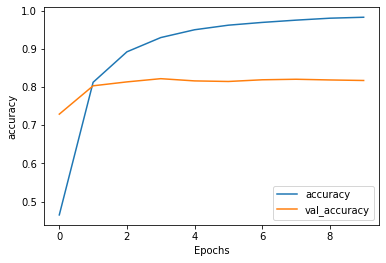

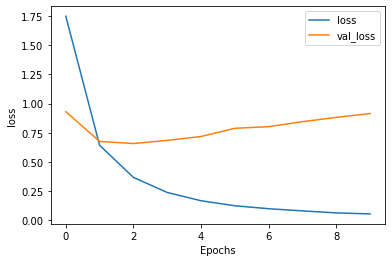

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
del training_label_seq
del train_articles
del train_labels
del validation_label_seq
del validation_articles
del validation_labels

**Prediction**

In [24]:
txt = ["Replacement Battery Kit for TOSHIBA E310/E355/E3XX"]
# ["High Speed Steel. Plug Style (most common hand tap). Ground Thread."]
# ["SuperNova is a unique biostimulant that will enhance any stage of a plants life. SuperNova is highly concentrated, requiring less product to obtain the maximum positive results."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels  = ['baby', 'all', 'arts', 'beauty', 'sports', 'grocery', 'cell', 'clothing',
 'tools', 'health', 'patio', 'electronics',
 'automotive', 'toys', 'office', 'appliances', 'musical', 'industrial', 'pet']
print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

[[5.7693262e-05 3.7586443e-02 6.2497348e-02 1.3601665e-01 2.6105348e-02
  5.2308756e-01 2.6870063e-02 7.1393852e-03 1.8175086e-02 2.5403646e-03
  8.1109509e-02 1.7914830e-02 7.6651125e-04 7.5074746e-03 1.3195322e-02
  1.0116055e-02 1.5959614e-03 2.6719309e-03 1.9800246e-02 5.2462276e-03]]
5
sports
